In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime, date
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Our dataset is a set of issues of a newspaper called *The Liberator* <https://en.wikipedia.org/wiki/The_Liberator_(newspaper)>, which was active for the last few decades of the abolitionist period.

In [2]:
#files = sorted(glob('TheLily/*'))
files = sorted(glob('TheLiberator/*'))

In [3]:
files[-3:]

['TheLiberator/1864-07-01.txt',
 'TheLiberator/1865-09-01.txt',
 'TheLiberator/1865-12-01.txt']

Let's build a vectorizer to read it in. 

Note the flag `binary`. If we set `binary=True`, this would mean that each word is counted at most once per document.

In [25]:
vect = CountVectorizer(input='filename',min_df=10,binary=False)

In [26]:
X = vect.fit_transform(files)

In [27]:
X.shape

(59, 8305)

**Your turn**: build another vectorizer, which includes all words that appear in at least 20 documents

In [28]:
vect2 = CountVectorizer(input='filename', min_df=20, binary=False) #your code
X2 = vect2.fit_transform(files)
print(X2.shape)

(59, 4547)


Let's print the most common words in 1851. To do this, we'll import `dateutil.parser`, which can parse the dates from the filenames.

In [29]:
from dateutil.parser import parse

In [30]:
parse(os.path.basename(files[4])[:-4])

datetime.datetime(1833, 6, 1, 0, 0)

In [31]:
# this list comprehension parses each of the dates in the filenames
dates = [parse(os.path.basename(filename)[:-4],'')
         for filename 
         in files]

In [32]:
print(dates[-3:])
print(files[-3:])

[datetime.datetime(1864, 7, 1, 0, 0), datetime.datetime(1865, 9, 1, 0, 0), datetime.datetime(1865, 12, 1, 0, 0)]
['TheLiberator/1864-07-01.txt', 'TheLiberator/1865-09-01.txt', 'TheLiberator/1865-12-01.txt']


Now we want to select a slice of X, corresponding only to editions in 1851.

We'll use the `enumerate` function to find the indices of dates that match the desired condition.

In [33]:
[(i,date) for i,date in enumerate(dates) if date.year==1851]

[(34, datetime.datetime(1851, 8, 1, 0, 0)),
 (35, datetime.datetime(1851, 11, 1, 0, 0))]

In [34]:
X_1851 = X[[i for i,date in enumerate(dates) if date.year==1851],]

In [35]:
X_1851.shape

(2, 8305)

So `X_1851` contains two instances, corresponding to the two editions published in 1851. (Actually, we're working with a small sample of the full dataset, there were several other editions published in that year.)

To find the most common words in this sample, let's construct an inverted index from the columns of `X` back to the vocabulary. 

In [36]:
ivoc = {j:i for i,j in vect.vocabulary_.items()}

In [37]:
[ivoc[i] for i in np.array(X_1851.sum(axis=0))[0].argsort()[::-1][:5]]

['the', 'of', 'and', 'to', 'in']

Not too interesting, but we're just getting started. 

**Your turn** Build a matrix containing the counts for editions published in the 1860s.

In [38]:
X_1860s = X[[i for i,date in enumerate(dates) if date.year>=1860 and date.year<=1869],]

In [39]:
# make sure you verify this
X_1860s.shape

(11, 8305)

# Pointwise mutual information

Rather than look at the most common words in each year or set of years, let's look at the words that have high *pointwise mutual information* with the year. This is defined as:

\begin{equation}
PMI(i,j) = \log \frac{P(i,j)}{P(i)\times P(j)} = \log P(i,j) - \log P(i) - \log P(j)
\end{equation}

We'll now introduce code to compute each part of this equation.

In [40]:
# this computes $p(i)$, where $i$ is a word
def get_p_word(X):
    X_tot = np.array(X.sum(axis=0))[0]
    return X_tot / X.sum()

In [41]:
P_base =get_p_word(X)

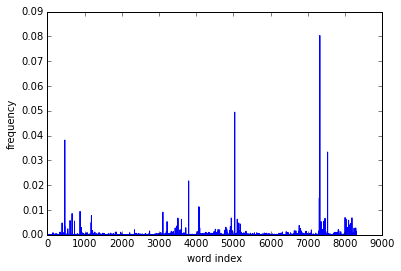

In [42]:
plt.plot(P_base)
plt.xlabel('word index')
plt.ylabel('frequency');

In [43]:
print([ivoc[i] for i in P_base.argsort()[::-1][:5]])
print(sorted(P_base)[::-1][:5])

['the', 'of', 'and', 'to', 'in']
[0.080353468880321952, 0.049455292548612188, 0.038205106504679551, 0.033368839757077697, 0.021727596662590724]


Now let's compute $P(year)$ and $P(word,year)$.

To do this, we'll write a function that returns a sum of word counts for a given year.

In [44]:
all_years = sorted(list(set([date.year for date in dates])))
print(all_years)

[1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865]


In [45]:
def get_X_year(X,dates,year):
    return np.array(X[[i for i,date in enumerate(dates) if date.year==year],].sum(axis=0))[0]

In [46]:
print(get_X_year(X,dates,1851))
print(X_1851.sum(axis=0))

[ 2 14  4 ...,  0  0  0]
[[ 2 14  4 ...,  0  0  0]]


Now let's create this vector for each year.

In [47]:
X_years = [get_X_year(X,dates,year) for year in all_years]

In [48]:
X_years[:3]

[array([ 0, 21,  3, ...,  2,  0,  0], dtype=int64),
 array([ 2, 11, 12, ...,  2,  3,  1], dtype=int64),
 array([47, 12,  5, ...,  0,  0,  1], dtype=int64)]

This is a list of arrays. We can combine this into a single array:

In [49]:
X_all_years = np.array(X_years)

In [50]:
P_year = X_all_years.sum(axis=1) / X_all_years.sum()

In [51]:
P_year

array([ 0.01411366,  0.02101902,  0.00972623,  0.04188513,  0.0143407 ,
        0.01494947,  0.0188828 ,  0.01691759,  0.05252363,  0.01493721,
        0.06889783,  0.06110763,  0.06352518,  0.06204324,  0.03534689,
        0.0140693 ,  0.02768742,  0.02650083,  0.01430919,  0.04323398,
        0.02164997,  0.01436113,  0.03003085,  0.02764773,  0.01518527,
        0.02963687,  0.01519111,  0.02934854,  0.01496873,  0.01472651,
        0.04676459,  0.01539072,  0.01451872,  0.0445951 ,  0.02996723])

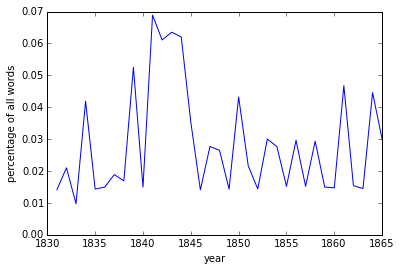

In [52]:
plt.plot(all_years,P_year)
plt.xlabel('year')
plt.ylabel('percentage of all words');

**Optional exercise** Create the same plot for months rather than years.

Now we're ready to compute the PMI.

In [53]:
all_years.index(1851)

20

In [54]:
X_all_years

array([[ 0, 21,  3, ...,  2,  0,  0],
       [ 2, 11, 12, ...,  2,  3,  1],
       [47, 12,  5, ...,  0,  0,  1],
       ..., 
       [ 0,  1, 10, ...,  0,  1,  0],
       [ 1, 20, 13, ...,  5,  2,  5],
       [ 1, 19,  6, ...,  3,  1,  1]], dtype=int64)

In [55]:
idx_1851 = all_years.index(1851)
pmi_1851 = np.log(X_all_years[idx_1851,:]/X_all_years.sum()) - np.log(P_base) - np.log(P_year[idx_1851])

That divide by zero error comes from taking the logarithm of zero, which will happen for every word that does not appear in the target year. Let's look at the output:

In [56]:
pmi_1851

array([-0.72112563,  0.1858105 , -0.8424113 , ...,        -inf,
              -inf,        -inf])

numpy handles this pretty well, putting a value of `-inf` in the list. 

that means we can go ahead and use argsort to find the highest PMI words.

In [57]:
[ivoc[i] for i in pmi_1851.argsort()[::-1][:5]]

['1851', 'austria', 'fraternity', 'problem', 'theyshould']

The top word is 1851! This is a good sign.

**Your turn** Write a function that takes the year as an argument, and returns the PMI for that year.

In [63]:
def get_pmi_year(X_all_years,P_base,p_year,year):
    # your code here
    idx_year = all_years.index(year)
    pmi_year = np.log(X_all_years[idx_year,:]/X_all_years.sum()) - np.log(P_base) - np.log(p_year[idx_year])
    return pmi_year

Here's how the output should look.

In [59]:
for year in all_years:
    print(year,[ivoc[i] for i in get_pmi_year(X_all_years,P_base,P_year,year).argsort()[::-1][:5]])

1831 ['weep', '1831', 'landlord', '1830', 'coach']
1832 ['cup', 'deaths', 'deputy', 'refute', 'cholera']
1833 ['planter', 'isle', 'spectator', '00', 'solomon']
1834 ['overseers', 'chorus', '1834', 'augusta', 'overseer']
1835 ['tracy', 'pull', '1835', 'purvis', 'madam']
1836 ['glasgow', 'opponent', 'kidnapped', 'boasting', 'searched']
1837 ['swallow', 'braintree', '1837', 'clerical', 'deprecate']
1838 ['mob', 'remonstrances', 'kidnappers', 'erected', 'nought']
1839 ['1839', 'harriet', 'disguise', 'marlboro', 'hilton']
1840 ['goodell', 'manifesto', 'harrison', 'follen', 'emancipator']
1841 ['1841', 'pierpont', 'lucretia', 'resistant', 'betrays']
1842 ['1842', 'trains', 'giddings', 'nelson', 'pauper']
1843 ['1843', 'stabbed', 'perkins', 'sham', 'bro']
1844 ['1844', 'birney', 'polk', 'bath', 'bates']
1845 ['writ', 'drunkenness', 'prosecuted', 'insurrections', 'employer']
1846 ['rio', 'drunkard', 'cobb', 'del', 'elegance']
1847 ['campbell', 'edinburgh', 'sand', 'thepoor', 'carved']
1848 ['1

These results suggest possibilities for further research: why was "drunkenness" a concern in 1845 and 1846, etc.

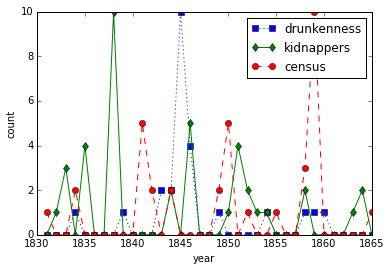

In [60]:
plt.plot(all_years,X_all_years[:,vect.vocabulary_['drunkenness']],'bs:')
plt.plot(all_years,X_all_years[:,vect.vocabulary_['kidnappers']],'gd-')
plt.plot(all_years,X_all_years[:,vect.vocabulary_['census']],'ro--')
plt.legend(['drunkenness','kidnappers','census'])
plt.ylabel('count')
plt.xlabel('year');

**Your turn**. Redo this analysis, using only words that appeared at least 50 times in the dataset.

In [65]:
# your code here
vect_50 = CountVectorizer(input='filename',min_df=50,binary=False)
X_50 = vect_50.fit_transform(files)
X_years_50 = [get_X_year(X_50,dates,year) for year in all_years]
X_all_years_50 = np.array(X_years_50)

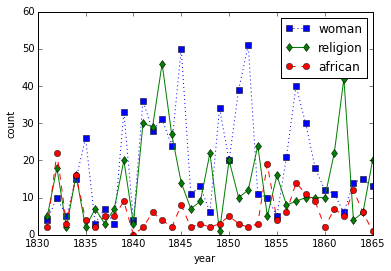

In [66]:
plt.plot(all_years,X_all_years_50[:,vect_50.vocabulary_['woman']],'bs:')
plt.plot(all_years,X_all_years_50[:,vect_50.vocabulary_['religion']],'gd-')
plt.plot(all_years,X_all_years_50[:,vect_50.vocabulary_['african']],'ro--')
plt.legend(['woman','religion','african'])
plt.ylabel('count')
plt.xlabel('year');

# Year-to-year similarity

Next, let's look for transitions in the data.

For each pair of years, we can compute the cosine similarity,

$\cos(x,y) = \frac{x \cdot y}{||x|| \times ||y||}$,

with $\cos(x,y) \in [0,1]$

In [67]:
corr = np.zeros(X_all_years.shape[0]-1)
for i,X_year in enumerate(X_all_years[:-1,]):
    corr[i] = X_year.dot(X_all_years[i+1,]) / ((np.linalg.norm(X_year)) * (np.linalg.norm(X_all_years[i+1,])))

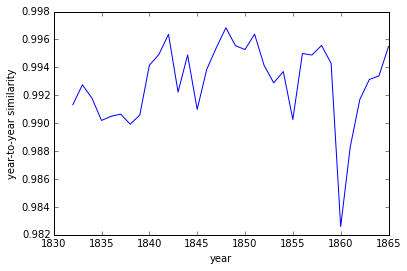

In [68]:
plt.plot(all_years[1:],corr)
plt.xlabel('year')
plt.ylabel('year-to-year similarity');

**Your turn:** Compute the cosine similarity of each year with the sum over the previous three years (when applicable)

In [69]:
offset = 3
corr_offset = [X_year.dot(X_all_years[i+offset,]) / (np.linalg.norm(X_year) * (np.linalg.norm(X_all_years[i+offset,]))) 
               for i, X_year in enumerate(X_all_years[:-offset])]

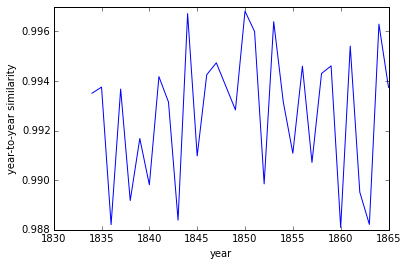

In [70]:
plt.plot(all_years[offset:],corr_offset)
plt.xlabel('year')
plt.ylabel('year-to-year similarity');

We see that these 3-year transitions are "spikier" but also contained in a smaller range than the 1-year transitions. More smoothing could separate long-term trends from random fluctuations.

## Lab extension: named entities during natural disaster
The dramatic change in social conditions during a natural disaster can result in significant linguistic variation: information shared is at a premium. 
During a disaster, news coverage often centers on named entities such as location names that are involved in the disaster ([Sarcevic et al. 2010](http://www.ischool.drexel.edu/faculty/aSarcevic/pub/p47-sarcevic.pdf)). 
Furthermore, if they are able to communicate, the victims of the disaster may provide more specific information about the situation than outside obsevers, including information on specific entities on-the-ground that were affected by the disaster ([Starbird, Muzny, Palen 2012](http://www.iscramlive.org/ISCRAM2012/proceedings/148.pdf)).

We pursue two research questions related to named entities in the context of Hurricane Maria, a storm that devastated Puerto Rico in late September 2017.

RQ1: Is the amount of named entity usage noticeably higher at the height of the disaster as compared to before and after the disaster?

RQ2: Does the distribution of named entity use change noticeably at the height of the disaster as compared to before and after the disaster?

Possible language-based RQs:

- More Spanish during hurricane?
- Bilingual individuals using more Spanish during hurricane?
- Less language similarity between days, users during hurricane (more surprising)?

To address this question, we use a dataset of tweets tagged with at least one of the hashtags `#Maria`, `#HurricaneMaria`, and `#PuertoRico` collected from September 18, 2017 through October 4, 2017. For reference, Hurricane Maria made landfall on Puerto Rico on September 20, 2017 and dissipated on October 3, 2017. 

## Load data

In [226]:
import pandas as pd
import os
import json
import gzip
data_dir = 'data/'
data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.gz')]
tweet_matrix = [[l.decode('utf-8').strip().split('\t') for l in gzip.open(f, 'r')] for f in data_files]
tweet_df = pd.concat([pd.DataFrame(t[1:], columns=t[0]) for t in tweet_matrix], axis=0)
# need to reset index
tweet_df.reset_index(inplace=True)
print('loaded %d tweets'%(tweet_df.shape[0]))

loaded 246783 tweets


Let's remove hyperlinks, which might get mistagged as entities.

In [227]:
import re
# url_matcher = re.compile('https*://[\w\s\./]+|pic.twitter.com/[\w\./]+')
url_matcher = re.compile('https?://[\S/\. ]+|pic.twitter.com/\S+')
tweet_df.loc[:, 'text'] = tweet_df.loc[:, 'text'].apply(lambda x: url_matcher.sub('', x))
# also get rid of extra quotes
tweet_df.loc[:, 'text'] = tweet_df.loc[:, 'text'].apply(lambda x: x.replace('"', ''))
# get rid of blank tweets
tweet_df = tweet_df[tweet_df.loc[:, 'text'] != '']

There's probably a lot of Spanish in here, but that actually isn't a bad thing because the hypotheses can still apply regardless of language and I think the Stanford NER tagger for Spanish isn't terrible.

In [228]:
from langid import classify
tweet_lang_list = tweet_df.loc[:, 'text'].apply(lambda x: classify(x)[0])
tweet_df.loc[:, 'lang'] = tweet_lang_list
tweet_lang_counts = tweet_lang_list.value_counts().sort_values(inplace=False, ascending=False)
print(tweet_lang_counts.head())

en    184979
es     34483
it     13203
fr      4130
pt      1102
Name: text, dtype: int64


To stay sane, we will focus on just the English and Spanish tweets.

In [229]:
valid_langs = ['en', 'es']
tweet_df_valid = tweet_df[tweet_df.loc[:, 'lang'].isin(valid_langs)]

Write clean text to file for named entity recognition.

In [235]:
from itertools import izip
import codecs
def write_txt_to_file(txt_series, file_name):
    """
    Write each line of text and its index to file.
    
    Parameters:
    -----------
    txt_series : pandas.Series
    file_name : str
    """
    N = txt_series.index.max()
    txt_series.sort_index(inplace=True)
    with codecs.open(file_name, 'w') as file_output:
        for i, l in izip(txt_series.index, txt_series):
            # need to include index to original dataframe
            l_clean = l.encode('utf-8').replace('\n', '')
            file_output.write('INDEX%d\t%s'%(i, l_clean))
            # add line break for every line except the last
            if(i < N):
                file_output.write('\n')

In [236]:
valid_langs = ['en', 'es']
for lang in valid_langs:
    tweet_df_lang = tweet_df[tweet_df.loc[:, 'lang'] == lang].loc[:, 'text']
    clean_txt_file = 'data/tweet_text_%s.txt'%(lang)
    write_txt_to_file(tweet_df_lang, clean_txt_file)

## Tag named entities

To tag named entities in English, we use the model developed by [Ritter et al. (2011)](https://aclanthology.info/pdf/D/D11/D11-1141.pdf), available for download [here](https://github.com/aritter/twitter_nlp).

To tag named entities in Spanish, we use the model developed as part of Stanford's CoreNLP package [here](http://nlp.stanford.edu/software/stanford-spanish-corenlp-2017-06-09-models.jar).

Outside of the notebook: 
- We run tag_english_txt.sh for the English data:

`bash tag_english_txt.sh`
- We run tag_spanish_txt.sh for the Spanish data (setup help [here](https://stackoverflow.com/questions/34037094/setting-nltk-with-stanford-nlp-both-stanfordnertagger-and-stanfordpostagger-fo)):

`bash tag_spanish_txt.sh`.

Let's check the results from both.

In [243]:
tweet_txt_tagged_en_file = 'data/tweet_text_en_ner.txt'
tweet_txt_tagged_es_file = 'data/tweet_text_es_ner.txt'
tweet_txt_tagged_en = [l.strip() for l in open(tweet_txt_tagged_en_file, 'r')]
tweet_txt_tagged_es = [l.strip() for l in open(tweet_txt_tagged_es_file, 'r')]

We need to clean these up a bit because of how we formatted the files.

In [241]:
# need to clean up the tags
# because there were some spaces inserted randomly
def clean_txt(txt_lines):
    """
    Clean the irregular spacing in text lines by
    using the index markers as line anchors.
    
    Parameters:
    -----------
    txt_lines : [str]
    
    Returns:
    --------
    fixed_txt : [str]
    """
    curr_txt = ''
    fixed_txt = []
    index_matcher = re.compile('(?<=INDEX)[0-9]+')
    for l in txt_lines:
        l = l.replace('\t', ' ')
        for t in l.split(' '):
            index_match = index_matcher.findall(t)
            if(len(index_match) > 0):
                index_match = index_match[0]
                if(curr_txt != ''):
                    fixed_txt.append(curr_txt)
                    curr_txt = index_match + '\t'
                else:
                    curr_txt = index_match + '\t'
            else:
                curr_txt += t + ' '
    # cleanup
    fixed_txt.append(curr_txt)
    return fixed_txt

In [244]:
tweet_txt_tagged_en = clean_txt(tweet_txt_tagged_en)
tweet_txt_tagged_es = clean_txt(tweet_txt_tagged_es)

Let's check the tagged entities to make sure that they make sense.

**English tags:**

In [245]:
print('\n'.join(tweet_txt_tagged_en[:10]))

1	#HurricaneMaria/O was/O Category/O ONE/O less/O than/O 18/O hours/O ago/O .../O @KRLD/O 
4	Will/O be/O a/O close/O call/O ,/O but/O some/O models/O take/O #Maria/O far/O enough/O north/O for/O the/O eyewall/O to/O miss/B-ENTITY Puerto/I-ENTITY Rico/I-ENTITY ./O 
6	#Maria/B-ENTITY is/O now/O a/O Category/O 5/O with/O sustained/O winds/O of/O 160mph/O ./O Wow/O ./O 
7	*/O #CARIBBEAN/O :/O MAJOR/B-ENTITY HURRICANE/I-ENTITY #MARIA/O -/O ALERT/B-ENTITY :/O #Dominica/O #Guadeloupe/O #Montserrat/B-ENTITY :/O Maria/B-ENTITY is/O now/O a/O .../O 
9	#HurricaneMaria/O Category/O 5/O 
10	DBS/B-ENTITY Radio/I-ENTITY plays/O religious/O music/O and/O talks/O over/O it/O .../O announcer/O just/O declared/O the/O sea/O was/O angry/O ./O #HurricaneMaria/O 
11	JUST/O IN/O :/O Hurricane/O hunters/O flying/O through/O #Maria/O find/O sustained/O winds/O of/O 160/O mph/O ;/O the/O storm/O is/O now/O a/O Category/O 5/O 
12	Trending/O now/O in/O LATAM/O :/O #NadieSeImaginaQ/O :/O #PERUMIN33/O :/O #PuertoRi

These are generally good!

- (4) `Puerto Rico` => `ENTITY`
- (7) `Maria` => `ENTITY`
- (10) `DBS Radio` => `ENTITY`

**Spanish tags:**

In [248]:
print('\n'.join(tweet_txt_tagged_es_fixed[:10]))

0	#URGENTE/O -/O HURACÁN/O #MARIA/O :/O Se/O dirige/O ahora/O a/O las/O islas/O Dominica/PERS y/O tiene/O vientos/O sostenidos/O de/O 257/O km/h/O ./O 
2	La/O probabilidad/O de/O que/O #María/O no/O nos/O parta/O tiene/O una/O correlación/O proporcional/O e/O inversa/O a/O la/O llegada/O de/O la/O Estadidad/LUG ./O #TweetSerio/O 
16	El/O huracán/O Maria/PERS nos/O va/O a/O partir/O como/O crayola/O de/O kinder/O .../O #PrayForPuertoRico/O #PuertoRico/O #HuracanMaria/O #pauti/O @SOYJOSHUAPAUTA/O 
25	Con/O vientos/O sostenidos/O de/O 160mph/ORG ,/O #Maria/O se/O convierte/O en/O huracán/O categoría/O 5/O ./O 
29	Me/O tinca/O que/O mañana/O comenzarán/O las/O transmisiones/O en/O cadena/O nacional/O del/O huracán/O #Maria/O 
30	a/O las/O 1900h/O #Maria/O es/O ahora/O categoria/O 5/O 
37	@COE_RD/O ordena/O evacuaciones/O preventivas/O a/O partir/O de/O mañana/O por/O huracán/O #María/O 
40	#URGENTE/O HURACÁN/O #MARIA/O :/O El/O Pdte/ORG Trump/ORG declara/O Estado/ORG de/O Emergencia/OTROS 

Some of these are pretty good!

- (2) `Estadidad` => `LUG` (lugar = "location")
- (16) `Maria` => `PERS`
- (40) `Pdte Trump` => `ORG`
- (53) `National Geographic` => `ORG`

Some are also pretty bad!

- (25) `160mph` => `ORG`
- (58) `huracán #Maria` => `O`

It seems like the good outweighs the bad, so let's include Spanish too.

In [255]:
tweet_txt_tagged_en_series = pd.Series(dict(t.split('\t') for t in tweet_txt_tagged_en))
tweet_txt_tagged_es_series = pd.Series(dict(t.split('\t') for t in tweet_txt_tagged_es))

In [256]:
tweet_txt_tagged_series = pd.concat([tweet_txt_tagged_en_series, tweet_txt_tagged_es_series], axis=0)
tweet_txt_tagged_series.index = map(int, tweet_txt_tagged_series.index)
tweet_txt_tagged_series = tweet_txt_tagged_series.sort_index()
print(tweet_txt_tagged_series.head())

0    #URGENTE/O -/O HURACÁN/O #MARIA/O :/O Se/O dir...
1    #HurricaneMaria/O was/O Category/O ONE/O less/...
2    La/O probabilidad/O de/O que/O #María/O no/O n...
4    Will/O be/O a/O close/O call/O ,/O but/O some/...
6    #Maria/B-ENTITY is/O now/O a/O Category/O 5/O ...
dtype: object


Recombine with original data frame.

In [258]:
tweet_df_valid = tweet_df_valid.assign(text_tagged=tweet_txt_tagged_series)

In [259]:
# save to file because paranoia
tweet_df_valid.to_csv('data/tweet_df_valid.tsv',encoding='utf-8', sep='\t')

In [1]:
# reloading because dead kernel
import pandas as pd
tweet_df_valid = pd.read_csv('data/tweet_df_valid.tsv',encoding='utf-8', sep='\t', index_col=0)

## Collect and count named entities
It will be easier to count the entities if we convert everything to a DTM.

In [2]:
def collect_entities_from_txt(txt):
    """
    Collect entity strings from text. NOTE: we assume
    that all adjacent strings tagged as "ENTITY" form
    part of the same entity, which is obviously not true
    for some cases, e.g., "the hurricane hit Puerto/ENT Rico/ENT, Guadelupe/ENT..."
    
    Parameters
    ----------
    txt : str
    
    Returns:
    --------
    entity_list : list
    """
    tokens = txt.strip().split(' ')
    entity_list = []
    entity_str = []
    outside_tag = 'O'
    for t in tokens:
        # split into text and tag
        t_pieces = t.split('/')
        t_txt = '/'.join(t_pieces[:-1])
        t_tag = t_pieces[-1]
        # build up entity string
        if(t_tag != outside_tag):
            entity_str.append(t_txt)
        # store and reset entity string
        elif(len(entity_str) > 0):
            entity_list.append('_'.join(entity_str))
            entity_str = []
    return entity_list

In [3]:
test_str = """
#URGENTE/O HURACÁN/O #MARIA/O :/O El/O Pdte/ORG Trump/ORG declara/O Estado/ORG de/O Emergencia/OTROS para/O Puerto/LUG Rico/LUG ./O 
"""
entity_list = collect_entities_from_txt(test_str)
print(entity_list)

['Pdte_Trump', 'Estado', 'Emergencia', 'Puerto_Rico']


Works great! Let's apply it to the whole dataset.

In [4]:
tweet_data_entity_lists = tweet_df_valid.loc[:, 'text_tagged'].apply(lambda x: collect_entities_from_txt(x))

**Sanity check**

Let's look at most popular named entities.

In [7]:
from collections import Counter
tweet_data_entity_counts = Counter(reduce(lambda x,y: x+y, tweet_data_entity_lists))
top_k = 10
print(tweet_data_entity_counts.most_common(top_k))

[(u'Puerto_Rico', 16554), (u'Trump', 6647), (u'Maria', 2563), (u'PR', 2444), (u'San_Juan', 1980), (u'Jones_Act', 1246), (u'Dominica', 1239), (u'America', 1155), (u'#Dominica', 1142), (u'Hurricane_Maria', 1054)]


These all make sense! 

It looks like hashtags can be counted as entities (`#Dominica`). As long as those are mostly locations then I don't think it will be a huge problem.

**DTM**

Now let's convert it to a DTM for more efficient processing.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
tweet_data_entity_lists_joined = map(lambda x: ' '.join(x), tweet_data_entity_lists)
# custom token pattern includes hashtags
token_pattern = '\S+'
cv = CountVectorizer(min_df=1, lowercase=False, strip_accents=None, token_pattern=token_pattern)
entity_dtm = cv.fit_transform(tweet_data_entity_lists_joined)

In [10]:
# check for top counts again
entity_dtm_sum = entity_dtm.sum(axis=0)
ivoc = {v : k for k,v in cv.vocabulary_.iteritems()}
top_k_entities = [ivoc[idx] for idx in pd.np.array(entity_dtm_sum.argsort())[0][::-1][:top_k]]
print(top_k_entities)

[u'Puerto_Rico', u'Trump', u'Maria', u'PR', u'San_Juan', u'Jones_Act', u'Dominica', u'America', u'#Dominica', u'Hurricane_Maria']


Top counts match between Counter and matrix sum! We're good to go.

## Compute entities per tweet
To get our entity tweet counts to address **RQ1**, we should compute the following statistics:

- entities per tweet ($E$)
- entities per tweet, normalized by word count ($E_{norm}$)
- unique entities per tweet ($E^{U}$)
- unique entities per tweet, normalized by word count ($E^{U}_{norm}$)

The normalized statistics will control for the possibility that longer tweets mention more entities, and the unique statistics will help with the diversity question.

In [74]:
from __future__ import division
from nltk.tokenize.casual import TweetTokenizer
tokenizer = TweetTokenizer()
words_per_tweet = tweet_df_valid.loc[:, 'text'].apply(lambda x: len(tokenizer.tokenize(x)))
# some tweets have zero characters 
entities_per_tweet = pd.np.array(entity_dtm.sum(axis=1))[:, 0]
entities_per_tweet_norm = entities_per_tweet / words_per_tweet.values

To get the unique counts, we convert the DTM to a binary matrix (if count greater than 1 => convert to 1).

In [76]:
import scipy as sp
entity_dtm_dummy = sp.sparse.coo_matrix(entity_dtm, dtype=int)
entity_dtm_dummy.data[:] = 1
entity_dtm_binary = entity_dtm.minimum(entity_dtm_dummy)

In [77]:
unique_entities_per_tweet = pd.np.array(entity_dtm_binary.sum(axis=1))[:, 0]
unique_entities_per_tweet_norm = unique_entities_per_tweet / words_per_tweet.values

Now let's add everything to the dataframe!

In [89]:
tweet_df_valid = tweet_df_valid.assign(entities_per_tweet=entities_per_tweet)
tweet_df_valid = tweet_df_valid.assign(entities_per_tweet_norm=entities_per_tweet_norm)
tweet_df_valid = tweet_df_valid.assign(unique_entities_per_tweet=unique_entities_per_tweet)
tweet_df_valid = tweet_df_valid.assign(unique_entities_per_tweet_norm=unique_entities_per_tweet_norm)

In [86]:
# correct for nan/inf values
tweet_df_valid.fillna(0, inplace=True)
tweet_df_valid.replace(pd.np.inf, 0, inplace=True)

In [94]:
# save to file again because of paranoia
tweet_df_valid.to_csv('data/tweet_df_valid.tsv', sep='\t', encoding='utf-8', index=False, index_label='index')

Sanity check: are these values correlated? If we plot them on a grid, we can find out.

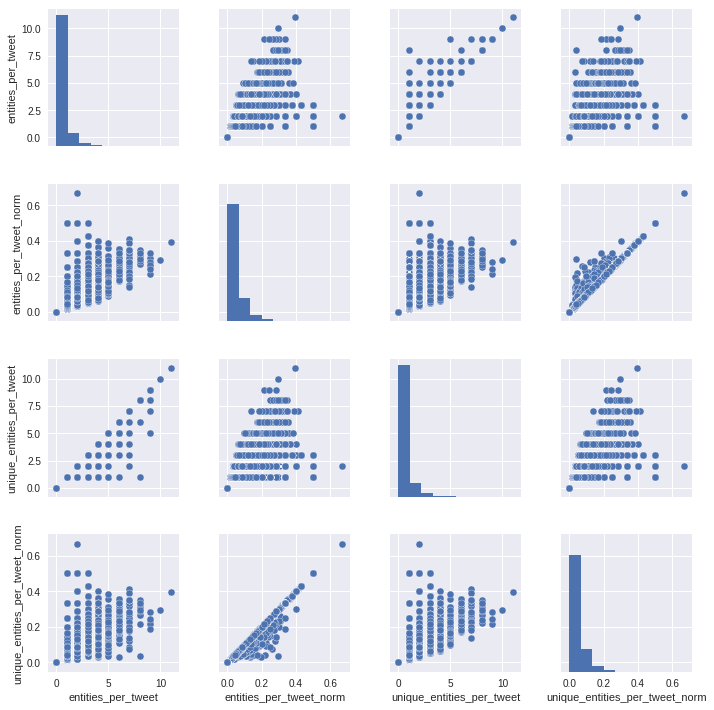

In [91]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
entity_cols = ['entities_per_tweet', 'entities_per_tweet_norm', 'unique_entities_per_tweet', 'unique_entities_per_tweet_norm']
sns.pairplot(tweet_df_valid.loc[:, entity_cols])
plt.show()

**Univariate**: These distributions have a heavy left-tail, since most tweets do not contain an entity mention.

**Multivariate**: As expected, the entities per tweet and unique entities per tweet are highly correlated. Same with normed entities per tweet and normed unique entities per tweet.

## Visualize time series
What does the overall time series for entities per hour look like?

We'll need to round all the dates down to the nearest hour, then compute the aggregate means for entities per tweet.

In [99]:
print(tweet_df_valid.loc[:, 'date'].values[0])

2017-09-18 19:59


In [100]:
from datetime import datetime
date_fmt = '%Y-%m-%d %H:%M'
tweet_df_valid = tweet_df_valid.assign(date_datetime=tweet_df_valid.loc[:, 'date'].apply(lambda x: datetime.strptime(x, date_fmt)))

In [108]:
tweet_df_valid = tweet_df_valid.assign(date_hour=tweet_df_valid.loc[:, 'date_datetime'].apply(lambda x: datetime(*x.timetuple()[:4])))

In [109]:
mean_entities_per_hour = tweet_df_valid.groupby('date_hour').apply(lambda x: x.loc[:, 'entities_per_tweet'].mean())

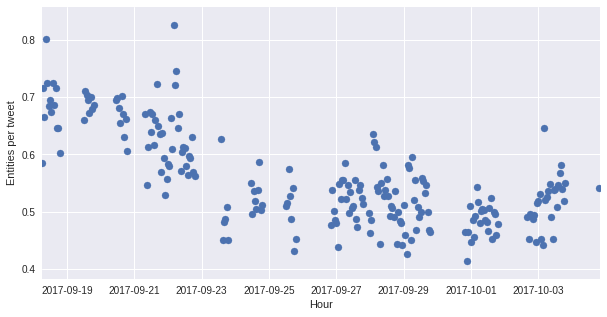

In [112]:
# plot time series
date_min = tweet_df_valid.loc[:, 'date_datetime'].min()
date_max = tweet_df_valid.loc[:, 'date_datetime'].max()
plt.figure(figsize=(10,5))
plt.scatter(mean_entities_per_hour.index, mean_entities_per_hour)
plt.xlim((date_min, date_max))
plt.xlabel('Hour')
plt.ylabel('Entities per tweet')
plt.show()

OK! So it looks like the entities per tweet ratio actually fell during and after the hurricane. Does this hold for all measures of entity frequency?

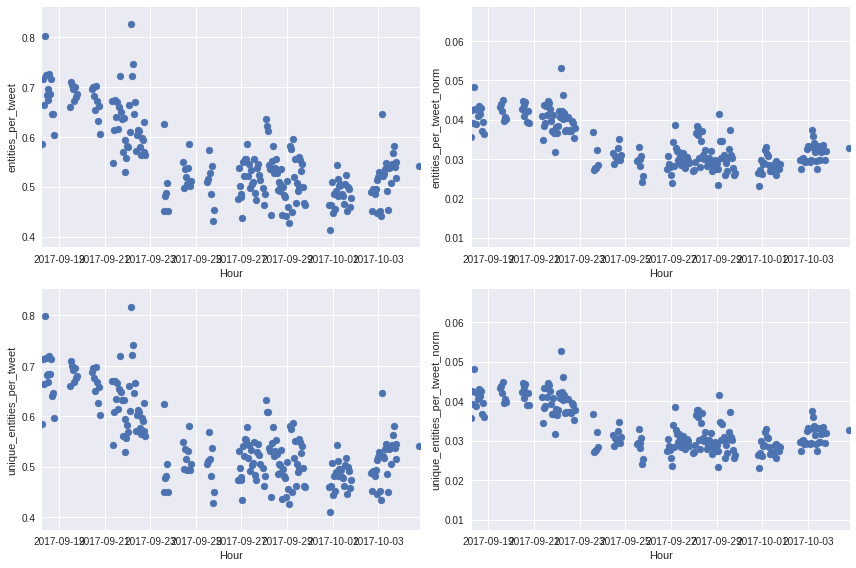

In [118]:
from math import ceil
cols = 2
rows = int(ceil(len(entity_cols) / cols))
fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
for i, entity_col in enumerate(entity_cols):
    mean_entities_per_hour = tweet_df_valid.groupby('date_hour').apply(lambda x: x.loc[:, entity_col].mean())
    r = int(i / cols)
    c = i % cols
    ax = axs[r, c]
    ax.scatter(mean_entities_per_hour.index, mean_entities_per_hour)
    ax.set_xlim((date_min, date_max))
    ax.set_xlabel('Hour')
    ax.set_ylabel(entity_col)
plt.tight_layout()
plt.show()

All the entity statistics follow basically the same trend, so let's stick with $E$ (entities per tweet) as our metric to test.

## Test RQ1
We can formalize RQ1 as a two-part hypothesis test to compare during-hurricane vs. before-hurricane (period B) and during-hurricane vs. after-hurricane (period A).

$H_{0,B}$: The average number of entities per tweet before the hurricane is roughly the same as the average number of entities per tweet during the hurricane.

$H_{1,B}$: The average number of entities per tweet before the hurricane is lower than the average number of entities per tweet during the hurricane.

$H_{0,A}$: The average number of entities per tweet after the hurricane is roughly the same as the average number of entities per tweet during the hurricane.

$H_{1,A}$: The average number of entities per tweet after the hurricane is lower than the average number of entities per tweet during the hurricane.

First we'll need to define what we mean by "before" and "after": we set the end of "before" as the date of landfall on Puerto Rico (9/20/17) and the beginning of "after" as the last date of noticeable impact on land (9/27/17; North Carolina).

In [119]:
hurricane_start_date = datetime.strptime('2017-09-20 06:00', '%Y-%m-%d %H:%M')
hurricane_end_date = datetime.strptime('2017-09-27 20:00', '%Y-%m-%d %H:%M')

In [ ]:
def hypothesis_test

## Compute entity diversity

To address RQ2, we compute two metrics of named entity diversity:

- entropy (per time period)
- cosine similarity (between time periods)

Under the null hypothesis, we expect that the entropy over named entities does not change significantly and that the cosine similarity is high.

In [ ]:
# entropy and cosine similarity shuffle test

## Test RQ2

## Conclusion

We can conclude...

## Discussion

I assume in this analysis that most of the tweets relating to Hurricane Maria were about Puerto Rico, such as the start and end date of the hurricane were the landfall dates for Puerto Rico. However we saw even from preliminary analysis that some of the content is about other areas, including Dominica, which suggests either (1) a wider time window of data for testing or (2) a more restricted dataset that only includes content about one location.

I was unable to generate entity classes for the English data, and it would have been interesting to compare the distribution of classes before, during and after the hurricane. For instance, I would expect more specific locations to be mentioned during the hurricane and more organizations to be mentioned afterward (e.g., relief organizations).

### References
Ritter, A., Clark, S., & Etzioni, O. (2011). Named Entity Recognition in Tweets: An Experimental Study. In EMNLP (pp. 1524–1534). 

Sarcevic, A., Palen, L., White, J., Starbird, K., Bagdouri, M., & Anderson, K. M. (2012). Beacons of Hope in Decentralized Coordination: Learning from On-the-Ground Medical Twitterers During the 2010 Haiti Earthquake. In Proceedings of the ACM 2012 conference on Computer Supported Cooperative Work (pp. 47–56). 

Starbird, K., Muzny, G., & Palen, L. (2012). Learning from the crowd: Collaborative filtering techniques for identifying on-the-Ground Twitterers during mass disruptions. Proceedings of 9th International Conference on Information Systems for Crisis Response and Management, ISCRAM, (April), 1–10. 